# Расчет цены на автомобиль
### Книга 04 - построение признаков

Постановка задачи:
Необходимо разработать модель, которая бы рассчитывала цену на выставленный на продажу автомобиль.  По условиям учебной задачи обучающих данных в явном виде не предоставлено. Только тестовые, собранные на авто-ру больше года назад. Необходимо самостоятельно разработать программу, которая бы собирала данные по объявлениям на том же сайте авто.ру. Дополнительная сложность - количество данных. Оцениваться работа будет по порядка 35к записей. Необходимо собрать порядка 140 тыс записей.  На самом сайте автору сейчас актуально порядка 90к объявлений.

С сайта авто.ру загружены два набора исходных данных:
- набор предложений по 12 брендам автомобилей (как в тестовом наборе), размером порядка 42к записей;
- набор предложений по 36 брендам автомобилей (как в данных от авторов задачи), размером порядка 91к записей.

Промежуточные выводы:
- При обучении по большому набору точность снижается. Использую малый набор.
- MAPE для простейшей модели дала довольно низкую точность - 53.46. Необходимо прежде всего скорректировать на инфляцию.

Ближайший план работы:
- Скорректировать цены на инфляцию.
- Сделать новые признаки.
- Сделать эксперименты с различными типами кодировщиков категориальных признаков.
- ... ?

В ходе работы над этим файлом столкнулся с двумя сложностями:
- Ошибка чтения файла данных выражалась в отказе от графического представления результатов работы пакетов графики, и пришлось все переписывать еще раз.
- Высокое разнообразие исходных данных.  Обучающий и тестовый массивы данных очень сильно отличаются по своему составу в части марок автомобителей. Этих марок всего порядка 5 сотен (высокая кардинальность), и примерно 10% являются уникальными для файла и представлены в нем в 1-2 экземплярах.

Я начинал работу с моделью в предположении что делаю функции, которые одинаково легко преобразуют и обучающую и тестовую выборки. Оказалось, что функций здесь мало, необходимы объекты, сохраняющие настройки алгоритма дл последующего повторного использования. Также необходимо посмотреть в то, какие значения признака есть в тестовых данных Для ускорения работы есть смысл перейти к совместной обработке учебного и проверочного массивов - как это и предлагается авторами в baseline-решении.

Результаты 21/11/29 - нашел ошибку в кодировщиках.  У меня много кодировщиков в текстовые значения, хотя часть из них представляет собой упорядоченные категории и их необходимо сразу кодировать правильно, а потом не перекодировать повторно. Завтра с утра надо поправить функции кодировки сначала во внешнем модуле, а потом и здесь.

Результаты 21/11/30 - прошел все новые признаки, провел их анализ по весомости и корреляции. Затем проверил результаты на Kaggle. Оказалось что Kaggle иногда дает результат лучше, чем рабочий ноутбук.  Добился лучшего результата на GradBoost - надо поднимать количество моделей во внешней функции.  Что еще надо сделать:
- внешняя функция добавления новых признаков;
- функции кодировки - целевая;
Целевая функция кодировки - вместо категориального признака помечается средним значением целевой переменной на этом признаке.



In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
import category_encoders as ce

import P05_01_lib as p05 # Модули с предыдущего ноутбука в виде отдельной библиотеки
RANDOM_SEED = 42

### Слияние двух наборов


In [2]:
train = pd.read_csv('input/211121-12brands.csv')
train.drop(['Unnamed: 0'], axis=1, inplace=True)
train['train'] = 1
test = pd.read_csv('input/test.csv')

In [3]:
test['price'] = 0.0
test['train'] = 0
df = pd.concat([test, train], join='inner', ignore_index=True)
df = p05.initial_transformation(df)
df.head()

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,sell_id,transmission,vendor,num_owners,gear,price,train,body_type,orig_license,left_steering
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105.0,B,74000.0,2013,OCTAVIA,...,1100575026,AMT,EUROPEAN,3,FWD,0,0,f_back,1,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110.0,B,60563.0,2017,OCTAVIA,...,1100549428,MT,EUROPEAN,1,FWD,0,0,f_back,1,1
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152.0,B,88000.0,2013,SUPERB,...,1100658222,AMT,EUROPEAN,1,FWD,0,0,f_back,1,1
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110.0,B,95000.0,2013,OCTAVIA,...,1100937408,AT,EUROPEAN,1,FWD,0,0,f_back,1,1
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152.0,B,58536.0,2008,OCTAVIA,...,1101037972,AT,EUROPEAN,1,FWD,0,0,f_back,1,1


### Обогащение внешними данными

Первоначальная версия этой книги предусматривала корректировку на инфляцию, как это описал Ментор А.Дзись во вводном семинаре по проекту - проанализировать цены по каждой марке по внешнему набору и скорректировать по каждой марке индивидуально по соответствующему набору.  Однако цена при это была очень далекой от оптимума.

Был предпринят ряд экспериментов (фактически однокоординатный спуск с фиксированным шагом) по MVP модели. Оказалось, что для минимальной оценки результат еще нужно домножать на 1.3. При этом результат улучшился до 22.08486.

Team-mate Tatjana предложила просто корректировать на инфляцию разделив текущие скачанные данные на тот же 1.3. В ряде последующих экспериментов было выяснено что оптимальный мультипликатор 0.78. При этом достигнут результат на Kaggle Kaggle 15.89045.

Выводы - предложенная ментором проекта методика корректировки на инфляцию по маркам раздельно оказалась хуже, чем простой подбор коэффициента без корректировки цен.  Правильнее будет использовать дальше оригинальные цены, скачанные с сайта авто.ру при работе над проектом и домножать их на поправочный коэффициент 0.78. В этой связи корректировка цен на инфляцию заменилась на обогащение признаками из внешнего файла.

При анализе данных выяснилось высокое разнообразие исходных данных.  Обучающий и тестовый массивы данных очень сильно отличаются по своему составу в части марок автомобителей. Этих марок всего порядка 5.5 сотен (высокая кардинальность), и примерно 10% являются уникальными для файла и представлены в нем в 1-2 экземплярах. То есть суммарно два набора отличаются примерно на 100 марок, представленных уникальными комбинациями.

Внешний файл представляет собор анализ парка моделей в первую очередь по размеру и типу автомобиля. Исполльзуется примерно европейская классификация - A,B,C,D,E,F причем и для обычных автомобилей, и для внедорожников и для микроавтобусов. Однако есть смешение типов автомобилей классов Grand Touring и спортивных автомобилей для гонок. Все эти автомобили сведены в один тип спортивное купе.

In [4]:
car_models = pd.read_csv('input/CarModels.csv')
# car_models.set_index('model', inplace=True)
# По каким-то причинам model привела к дублирующим индексам и вызывала ошибку
car_models.head()

,brand,model,eur_size,type,segment,geo
0,AUDI,100,E,Car,Prem,EUR
1,AUDI,200,E,Car,Prem,EUR
2,AUDI,80,D,Car,Prem,EUR
3,AUDI,90,D,Car,Prem,EUR
4,AUDI,920,D,Car,Prem,EUR


In [5]:
p05 = reload(p05)

Функция обогащения внешними признаками перекочевала во внешнюю библиотеку после написания и отладки.

In [6]:
df = p05.add_external_features(df, car_models)
df.head()

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,gear,price,train,body_type,orig_license,left_steering,size_cat,sport_car,euro_car,premium
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105.0,B,74000.0,2013,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110.0,B,60563.0,2017,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152.0,B,88000.0,2013,SUPERB,...,FWD,0,0,f_back,1,1,4,0,1,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110.0,B,95000.0,2013,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152.0,B,58536.0,2008,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0


In [7]:
df.drop(['vendor'], axis=1, inplace=True)

In [8]:
df.columns

Index(['body', 'brand', 'url', 'color', 'displacement', 'power', 'fuel',
       'mileage', 'model_year', 'model', 'doors', 'manuf_year', 'sell_id',
       'transmission', 'num_owners', 'gear', 'price', 'train', 'body_type',
       'orig_license', 'left_steering', 'size_cat', 'sport_car', 'euro_car',
       'premium'],
      dtype='object')

In [9]:
cat_cols = ['brand', 'color', 'fuel', 'model', 'transmission',  'gear', 'body_type']
dig_cat = ['euro_car', 'premium', 'sport_car', 'size_cat', 'orig_license','left_steering','num_owners', 'doors' ]
num_cols = [ 'displacement', 'power', 'mileage', 'manuf_year']
help_cols = ['sell_id','body','url','model_year', 'price']
target = ['price']

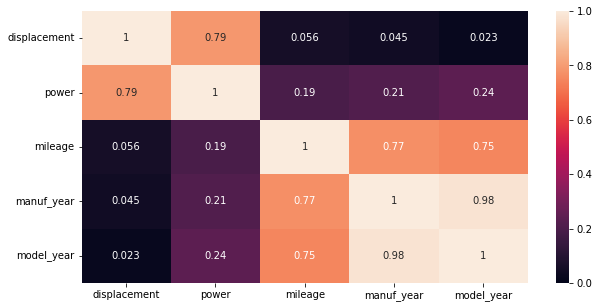

In [10]:
plt.figure(figsize=(10, 5))
sns.heatmap(df[num_cols+['model_year']].corr().abs(), vmin=0, vmax=1, annot=True)
plt.show()

Между двумя парами количественных переменных - power & displacement,  mileage & manuf_year есть сильная кореляция. Есть смысл сделать признаки, которые бы выявляли разницу между этими показателями.
Между model_year и manuf_year зависимость очень высокая. Практически нет смысла держать второй показатель - модельный год.

In [11]:
rg_enc = p05.parse_ranging_encoder(df,cat_cols)
new_cat_cols, df = p05.apply_encoder(df, cat_cols, rg_enc)

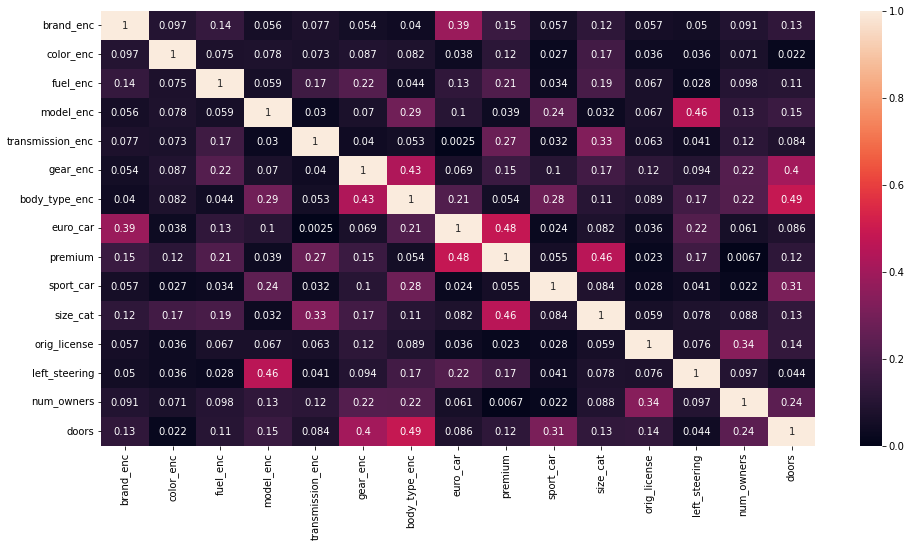

In [12]:
plt.figure(figsize=(16,8))
sns.heatmap(df[new_cat_cols+dig_cat].corr().abs(), vmin=0, vmax=1, annot=True)
plt.show()

Критичных зависимостей между катеориальными признаками нет.  Любопытна корреляция между страной происхождения и сегментом - в выборке европейские машины в основном в премиальном сегменте.  Также любопытна корреляция между названием модели и расположением руля - в данных много предложений по праворульным машинам для японского рынка.

In [85]:
model_cols = num_cols + dig_cat + new_cat_cols

In [86]:
p05 = reload(p05)

In [88]:
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
m = 0
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for trn_index, tt_index in kf.split(X):
    X_trn = X[trn_index] ; X_tt =  X[tt_index]
    y_trn = y[trn_index] ; y_tt =  y[tt_index]
    # rfr_log.fit(X_train, np.log(y_train))
    # predict_rf_log = np.exp(rfr_log.predict(X_test))
    rfr.fit(X_trn, np.log(y_trn))
    y_prd = np.exp(rfr.predict(X_tt))
    m += p05.mape(y_tt, y_prd) * 100.0
m  /= 5

print(f"The MAPE metric for the Random Forest model on ln(price) : {m:0.4f}%.")

The MAPE metric for the Random Forest model on ln(price) : 11.6439%.


На одиночной выборке при 100 деревьях в лесу у меня был результат 11.5912% При использовании кросс-валидации на 5 складках и леса из 200 деревьев при помарочном учете инфляции результат получился 11.7508%. Это может свидетельствовать в пользу необходимости применения целевого кодирования. (Или свидетельствовать о некотором переобучении.) При неизменных ценах и до обогащения результат был 11.7698%.  Сейчас результат после обогащения данными стал 11.6439, что подтверждает правильность и полезность работы по формированию справочника и обогащения признаками с его помощью.

In [89]:
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr.fit(X,np.log(y))

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [91]:
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.78
# subm = tdf[['sell_id','price']]
subm.to_csv(f'211130_subm_11.csv', index=False)
subm.head(5)

,sell_id,price
0,1100575026,6.226812e+05
1,1100549428,1.090722e+06
2,1100658222,9.301551e+05
3,1100937408,7.889522e+05
4,1101037972,6.844657e+05


Уровень оценки на kaggle первоначально был 30.00270. В ходе поиска удалось снизить значение оценки на kaggle до путем умножения цены на 1.3. Получен счет 22.08486
 По совету team-mate был произведен переход на корректировку непосредственно текущих цен и результат был получен на уровне 15.8425.

Текущий результат на Kaggle 15.71750.  Это также подтверждает правильность подхода по обогащению внешними признаками.

### Анализ влияния цвета
Коллега тим-мейт предложила еще отборосить цвет как мало влияющий показатель. Попробую проанализировать влияние цвета.

In [58]:
df.color.value_counts(ascending=False)

чёрный         23789
белый          15125
серый           9918
серебристый     7549
синий           7344
коричневый      3398
красный         3342
зелёный         1934
бежевый         1404
голубой          814
пурпурный        499
золотистый       452
оранжевый        396
фиолетовый       381
жёлтый           365
розовый           21
Name: color, dtype: int64

In [63]:
df['log_price'] = np.log1p(df.price)

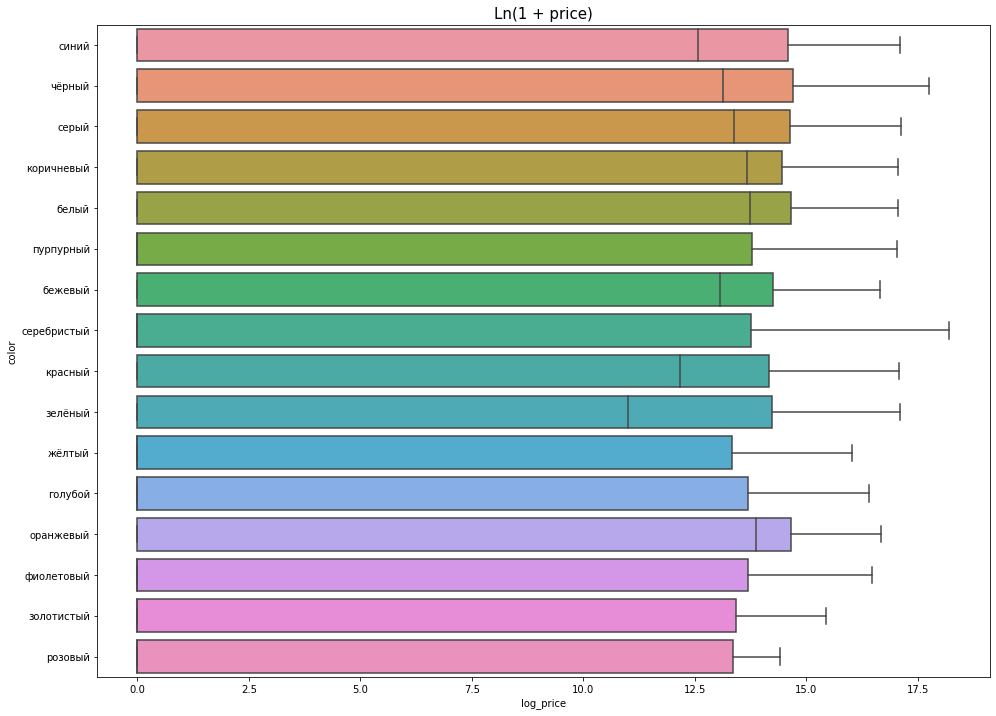

In [64]:
plt.figure(figsize = (16,12))
sns.boxplot(x= 'log_price', y = 'color', data=df, orient='h')
plt.title('Ln(1 + price)', fontsize=15)
plt.show();

Совет коллеги не подствержден.  Цены даже в среднем существенно различаются в зависимости от цвета. Отбрасывать этот признак не целесообразно. Однако это показатель с высокой кардинальностью.

### Создание рабочей модели

В качестве модели для проверки качества на этапе разработки будет использован набор из нескольких моделей. По опыту можно предположить что не все модели одинаково хорошо реагируют на новые признаки. Исходя из предыдущего опыта использованы два варианта случайного леса и два ансамбля с бустингом.

В первоначальном варианте я использовал модели с типовыми параметрами. Опыт показал, что количество эстиматоров в моделях бустинга лучше попробовать поднять до 1000.  В ходе экспериментов с данным рабочим листом пришел к выводу, что AdaBst не обеспечивает хорошего результата и закоментировал этот вариант модели.

Функция eval_data () вынесена в библиотеку.

In [171]:
p05 = reload(p05)

In [172]:
m = p05.eval_data(df.query('train==1')[model_cols], df.query('train==1').price,'IA')
print(m)

Eval: ExtEns AdaBst GradBst RanFrst done. 300.1999 sec
ExtEns     11.852852
AdaBst     31.723193
GradBst    12.087278
RanFrst    11.679512
Name: IA, dtype: float64


### Разработка признаков

Из общих соображений можно сделать следующие признаки:
- Срок владения машиной (разница 2021 и года выпуска)
- Пробег в год - интенсивность эксплуатации (логарифм?)
- Категорийный признак с интенсивностью пробега в год (до 15к, до 30к, свыше 30к)
- Возраст - новая, до 5 лет, до 10 лет, до 50 лет, свыше 50 лет - посмотреть на границы
- Новизна модели - разница между годом выпуска и модельным годом (модельный год был устранен)
- Сделать тип машинки со следующей классификацией: 0 - купе, 1 - седан, хетчбек или универсал, 2 - внедорожник, 3 - микроавтобус.  Будет сильно коррелировать с типом кузова?

Учитывая, что подгружен размер авто по европейской классификации:
- сделать энергичность машинки - мощность поделить на размер. Для класса S принять размер равный размеру С (3).
- удельный литраж машинки - объем поделить на размер авто.

Есть смысл вернуться и переделать классификацию - все спортивные машинки сделать размера C - переделано.


#### Возраст

Первоначально я не учел тот факт, что тестовый набор данных собирался больше года назад и в нем физически не может быть автомобилей 2021 года выпуска. Сейчас эта оплошность устранена. Посмотрим, как она повлияет на итоговый результат.


In [13]:
df['age'] = 2020 + df.train - df.manuf_year
# train.age.max()
p05.show_quantile_hurdle(df.age)

0.00      0.0
0.25      3.0
0.50      8.0
0.75     13.0
0.95     23.0
1.00    116.0
Name: age, dtype: float64

 Low hurdle: -12.0000 high hurdle: 28.0000


In [14]:
p05.show_quantile_hurdle(df.query('train==1').age)

0.00     0.0
0.25     0.0
0.50     5.0
0.75    10.0
0.95    21.0
1.00    84.0
Name: age, dtype: float64

 Low hurdle: -15.0000 high hurdle: 25.0000


Интересно что квартили для обучающих данных из интернета  оказались распределены по "отраслевой журналистике" - до 5, до 10, до 21 года и выше.  Для тестовых данных распределение совсем другое.  Есть смысл ограничить возраст сверху 30 годами.  В России старше 30 лет будет антиквариат.

In [15]:
p05.show_quantile_hurdle(df.query('train==0').age)


0.00      0.0
0.25      6.0
0.50      9.0
0.75     14.0
0.95     24.0
1.00    116.0
Name: age, dtype: float64

 Low hurdle: -6.0000 high hurdle: 26.0000


In [18]:
df.loc[df.age>70].head(10)

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,euro_car,premium,brand_enc,color_enc,fuel_enc,model_enc,transmission_enc,gear_enc,body_type_enc,age
1777,хэтчбек,SKODA,https://auto.ru/cars/used/sale/skoda/popular/1...,чёрный,1.1,30.0,B,14000.0,1934,POPULAR,...,1,0,5,15,4,64,2,0,3,81
3174,седан,AUDI,https://auto.ru/cars/used/sale/audi/920/109152...,чёрный,3.3,75.0,B,90000.0,1938,920,...,1,1,6,15,4,71,2,0,4,82
9495,седан,BMW,https://auto.ru/cars/used/sale/bmw/321/1093991...,чёрный,2.0,46.0,B,25000.0,1937,321,...,1,1,10,15,4,193,2,0,4,71
9625,седан,BMW,https://auto.ru/cars/used/sale/bmw/326/1094373...,бежевый,2.0,51.0,B,16000.0,1936,326,...,1,1,10,7,4,45,2,0,4,83
9819,седан,BMW,https://auto.ru/cars/used/sale/bmw/321/1040149...,чёрный,2.0,46.0,B,4500.0,1937,321,...,1,1,10,15,4,193,2,0,4,83
16891,седан,MERCEDES-BENZ,https://auto.ru/cars/used/sale/mercedes/w136/1...,красный,1.7,38.0,B,10.0,1936,W136,...,1,1,11,9,4,120,2,0,4,84
16944,кабриолет,MERCEDES-BENZ,https://auto.ru/cars/used/sale/mercedes/simple...,белый,5.3,32.0,B,48000.0,1904,SIMPLEX,...,1,1,11,14,4,27,2,0,0,116
33748,седан,BMW,https://auto.ru/cars/used/sale/bmw/321/1092197...,коричневый,2.0,46.0,B,10.0,1937,321,...,1,1,10,10,4,193,2,0,4,72
35247,седан,BMW,https://auto.ru/cars/used/sale/bmw/321/1106015...,чёрный,2.0,46.0,B,30000.0,1937,321,...,1,1,10,15,4,193,2,0,4,84
70910,седан,BMW,https://auto.ru/cars/used/sale/bmw/321/1104655...,бежевый,2.0,46.0,B,4500.0,1937,321,...,1,1,10,7,4,193,2,0,4,75


Любопытно, что в тестовом наборе есть а/м 1904 года выпуска, что безусловно является выбросом данных.


In [19]:
df.age = df.age.apply(lambda x: x if x <=30. else 30.0 )
df['age_cat'] = df.age.apply(lambda x: 0 if x<=5 else (1 if x<=10 else ( 2 if x<=20 else 3 )))
df.age_cat.value_counts(normalize=True)

0    0.386623
1    0.286455
2    0.250603
3    0.076319
Name: age_cat, dtype: float64

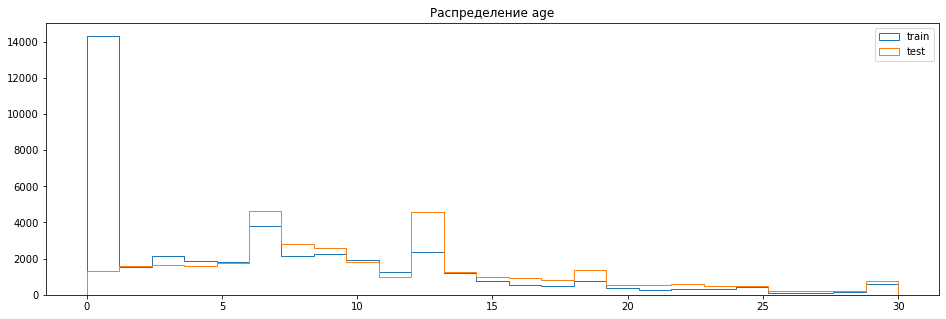

In [20]:
plt.figure(figsize=(16,5))
plt.hist(df.query('train==1').age,bins=25,histtype='step',label='train')
plt.hist(df.query('train==0').age,bins=25,histtype='step',label='test')
plt.legend(loc='best')
plt.title('Распределение age');

Интересно, что после корректировки формулы возраста распределение у тестовых и обучающих данных изменилось. У тестовой выборки полявились новые а/м.

#### Пробег

Годовой пробег и пробег

In [176]:
df['ann_mil'] = df.apply(lambda t: 5 if t['age']<1 else t['mileage']/t['age'], axis=1)
p05.show_quantile_hurdle(df.ann_mil)

0.00         0.117647
0.25      7666.666667
0.50     13125.000000
0.75     18066.666667
0.95     29285.714286
1.00    210000.000000
Name: ann_mil, dtype: float64

 Low hurdle: -7933.3333 high hurdle: 33666.6667


Посчитаем по квартилям наличие выброса сверху.

Существует выброс по годовому пробегу. Имеет смысл ограничить пробег сверху.

In [117]:
df.ann_mil = df.ann_mil.apply(lambda x: x if x < 33800 else 33800)
df['intensity'] = df.ann_mil.apply(lambda x: 0 if x <= 15000 else 1 )

In [177]:
p05.show_quantile_hurdle(df.mileage)

0.00        10.0
0.25     40520.5
0.50    120000.0
0.75    193000.0
0.95    324217.0
1.00    420000.0
Name: mileage, dtype: float64

 Low hurdle: -188198.7500 high hurdle: 421719.2500


Ограничим пробег сверху на уровне 420000

In [120]:
df.mileage = df.mileage.apply(lambda m: m if m <420000 else 420000)


Вспомогательный признак размера пробега автомобиля (степени изношенности его узлов)

In [121]:
df['tot_mil'] = df.mileage.apply(lambda m: 0 if m <50000 else( 1 if m <100000 else (2 if m <200000 else 3)))

####  Мощность и удельная мощность

Логарифм мощности, удельная мощность на ед.объема, удельная мощность на размер автомобиля

In [122]:
df['power_size'] = df.power / df.size_cat

In [164]:
p05.show_quantile_hurdle(df.power_size)

0.00      7.600000
0.25     39.166667
0.50     49.000000
0.75     61.166667
0.95     88.333333
1.00    223.333333
Name: power_size, dtype: float64

 Low hurdle: 6.1667 high hurdle: 94.1667


In [165]:
show_quantile_hurdle(df.power)

0.00     30.0
0.25    140.0
0.50    170.0
0.75    245.0
0.95    380.0
1.00    800.0
Name: power, dtype: float64

 Low hurdle: -17.5000 high hurdle: 402.5000


У мощности и удельной мощности очень тяжелый хвост - много значений намного выше границы обычного среднего распределения.  Точнее говоря, наверное есть несколько распределений в зависимости от типа авто

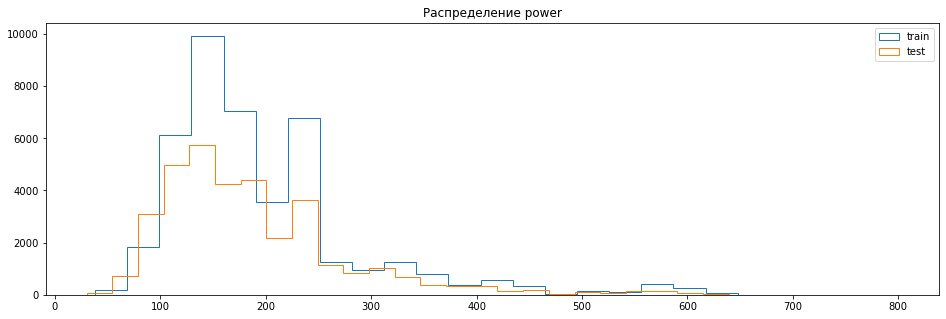

In [125]:
plt.figure(figsize=(16,5))
plt.hist(df.query('train==1').power,bins=25,histtype='step',label='train')
plt.hist(df.query('train==0').power,bins=25,histtype='step',label='test')
plt.legend(loc='best')
plt.title('Распределение power');

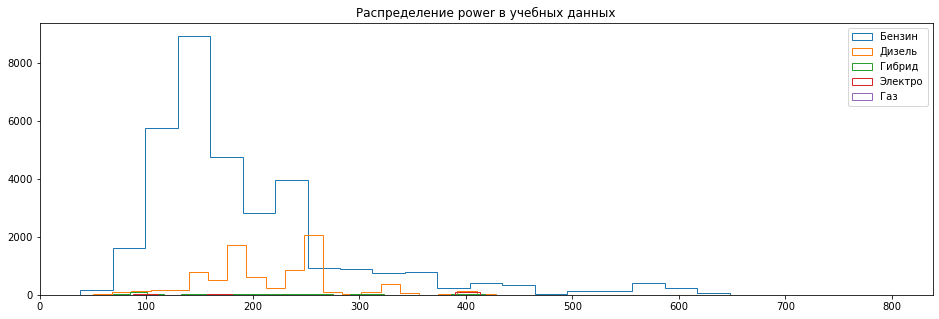

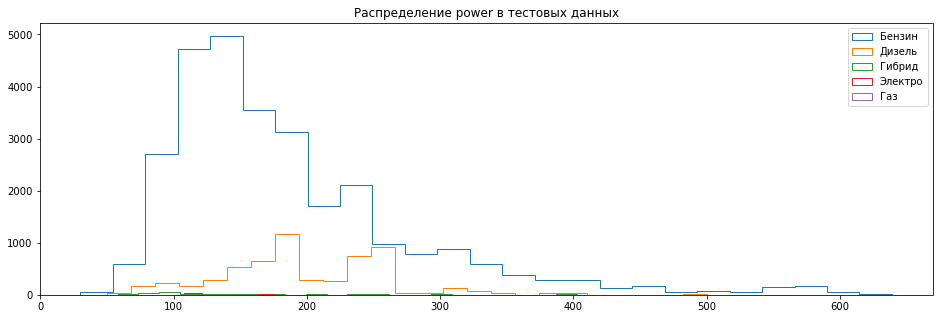

In [126]:
plt.figure(figsize=(16,5))
plt.hist(df.query("train==1 & fuel =='B'").power,bins=25,histtype='step',label='Бензин')
plt.hist(df.query("train==1 & fuel =='D'").power,bins=25,histtype='step',label='Дизель')
plt.hist(df.query("train==1 & fuel =='H'").power,bins=25,histtype='step',label='Гибрид')
plt.hist(df.query("train==1 & fuel =='E'").power,bins=25,histtype='step',label='Электро')
plt.hist(df.query("train==1 & fuel =='G'").power,bins=25,histtype='step',label='Газ')
plt.legend(loc='best')
plt.title('Распределение power в учебных данных');
plt.figure(figsize=(16,5))
plt.hist(df.query("train==0 & fuel =='B'").power,bins=25,histtype='step',label='Бензин')
plt.hist(df.query("train==0 & fuel =='D'").power,bins=25,histtype='step',label='Дизель')
plt.hist(df.query("train==0 & fuel =='H'").power,bins=25,histtype='step',label='Гибрид')
plt.hist(df.query("train==0 & fuel =='E'").power,bins=25,histtype='step',label='Электро')
plt.hist(df.query("train==0 & fuel =='G'").power,bins=25,histtype='step',label='Газ')
plt.legend(loc='best')
plt.title('Распределение power в тестовых данных');

Существует очень длинный хвост у распределений значений признака power.  Явной зависимости от типа двигателя не найдено.


In [127]:
df['log_power'] = np.log10(df.power)


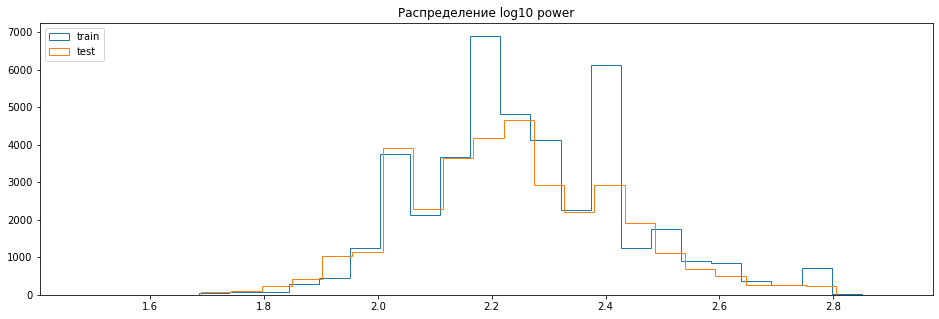

In [128]:
plt.figure(figsize=(16,5))
plt.hist(df.query('train==1').log_power,bins=25,histtype='step',label='train')
plt.hist(df.query('train==0').log_power,bins=25,histtype='step',label='test')
plt.legend(loc='best')
plt.title('Распределение log10 power');

In [166]:
show_quantile_hurdle(df.log_power)

0.00    1.781600
0.25    2.146128
0.50    2.230449
0.75    2.389166
0.95    2.579784
1.00    2.753700
Name: log_power, dtype: float64

 Low hurdle: 1.7816 high hurdle: 2.7537


После 10-тичного логарифмирования распределение стало гораздо сильнее напоминать нормальное.  Ограничим логарифм мощность от выбросов сверху и снизу.

In [132]:
df.log_power = df.log_power.apply(lambda x: 1.7816 if x <1.7816 else (x if x < 2.7537 else 2.7537))


In [133]:
df['vol_power'] = df.apply(lambda t: 0 if t['displacement']<0.1 else t['power']/t['displacement'], axis=1)

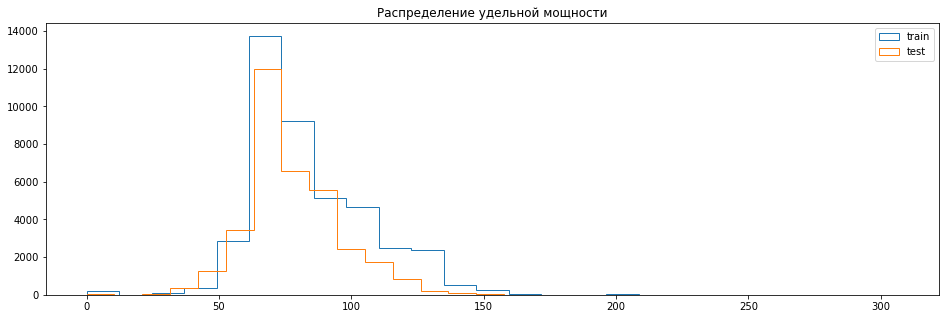

In [134]:
plt.figure(figsize=(16,5))
plt.hist(df.query('train==1').vol_power,bins=25,histtype='step',label='train')
plt.hist(df.query('train==0').vol_power,bins=25,histtype='step',label='test')
plt.legend(loc='best')
plt.title('Распределение удельной мощности');

In [167]:
show_quantile_hurdle(df.vol_power)

0.00      0.000000
0.25     68.750000
0.50     76.000000
0.75     92.000000
0.95    124.500000
1.00    306.666667
Name: vol_power, dtype: float64

 Low hurdle: 33.8750 high hurdle: 126.8750


In [136]:
df['log_vol_power'] =  np.log10(df.vol_power+1)

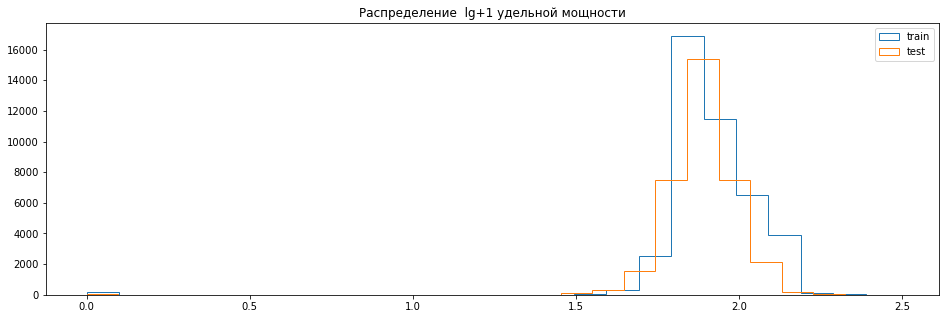

In [137]:
plt.figure(figsize=(16,5))
plt.hist(df.query('train==1').log_vol_power,bins=25,histtype='step',label='train')
plt.hist(df.query('train==0').log_vol_power,bins=25,histtype='step',label='test')
plt.legend(loc='best')
plt.title('Распределение  lg+1 удельной мощности');

In [168]:
show_quantile_hurdle(df.log_vol_power)

0.00    0.000000
0.25    1.843544
0.50    1.886491
0.75    1.968483
0.95    2.098644
1.00    2.160000
Name: log_vol_power, dtype: float64

 Low hurdle: 1.6561 high hurdle: 2.1559


Есть большое желание ограничить этот показатель снизу. Но для электромобилей этот показатель естественно равен нулю.  Оставлю без ограничения снизу.

In [141]:
# df.log_vol_power = df.log_vol_power.apply(lambda x: 1.656 if x <1.656 else (x if x < 2.156 else 2.156))
df.log_vol_power = df.log_vol_power.apply(lambda x: x if x < 2.156 else 2.16)


#### Проверка значимости и взаимной корреляции признаков

In [142]:
df.columns

Index(['body', 'brand', 'url', 'color', 'displacement', 'power', 'fuel',
       'mileage', 'model_year', 'model', 'doors', 'manuf_year', 'sell_id',
       'transmission', 'num_owners', 'car_license', 'gear', 'steering',
       'price', 'train', 'body_type', 'orig_license', 'left_steering',
       'size_cat', 'sport_car', 'euro_car', 'premium', 'brand_enc',
       'color_enc', 'fuel_enc', 'model_enc', 'transmission_enc', 'gear_enc',
       'body_type_enc', 'power_size', 'age', 'age_cat', 'ann_mil', 'intensity',
       'tot_mil', 'log_power', 'vol_power', 'log_vol_power'],
      dtype='object')

cat_cols = ['brand', 'color', 'fuel', 'model', 'transmission',  'gear', 'body_type']
dig_cat = ['euro_car', 'premium', 'sport_car', 'size_cat', 'orig_license','left_steering','num_owners', 'doors' ]
num_cols = [ 'displacement', 'power', 'mileage', 'manuf_year']
help_cols = ['sell_id','body','url','model_year', 'price']
target = ['price']

In [149]:
cat_cols = ['brand', 'color', 'fuel', 'model', 'transmission',  'gear', 'body_type']
dig_cat = ['euro_car', 'premium', 'sport_car', 'size_cat', 'orig_license','left_steering','num_owners', 'doors', 'age_cat', 'intensity', 'tot_mil' ]
num_cols = [ 'displacement', 'power', 'mileage', 'manuf_year']
num_cols2 = [ 'age', 'ann_mil', 'log_power', 'vol_power', 'log_vol_power', 'power_size']
help_cols = ['sell_id','body','url','model_year', 'price20']
target = ['price']

In [150]:
print(new_cat_cols)

['brand_enc', 'color_enc', 'fuel_enc', 'model_enc', 'transmission_enc', 'gear_enc', 'body_type_enc']


Необходимо проверить значимость и корреляцию по новым признакам.

In [151]:
all_model_cols = new_cat_cols + dig_cat + num_cols + num_cols2
print(all_model_cols)

['brand_enc', 'color_enc', 'fuel_enc', 'model_enc', 'transmission_enc', 'gear_enc', 'body_type_enc', 'euro_car', 'premium', 'sport_car', 'size_cat', 'orig_license', 'left_steering', 'num_owners', 'doors', 'age_cat', 'intensity', 'tot_mil', 'displacement', 'power', 'mileage', 'manuf_year', 'age', 'ann_mil', 'log_power', 'vol_power', 'log_vol_power', 'power_size']


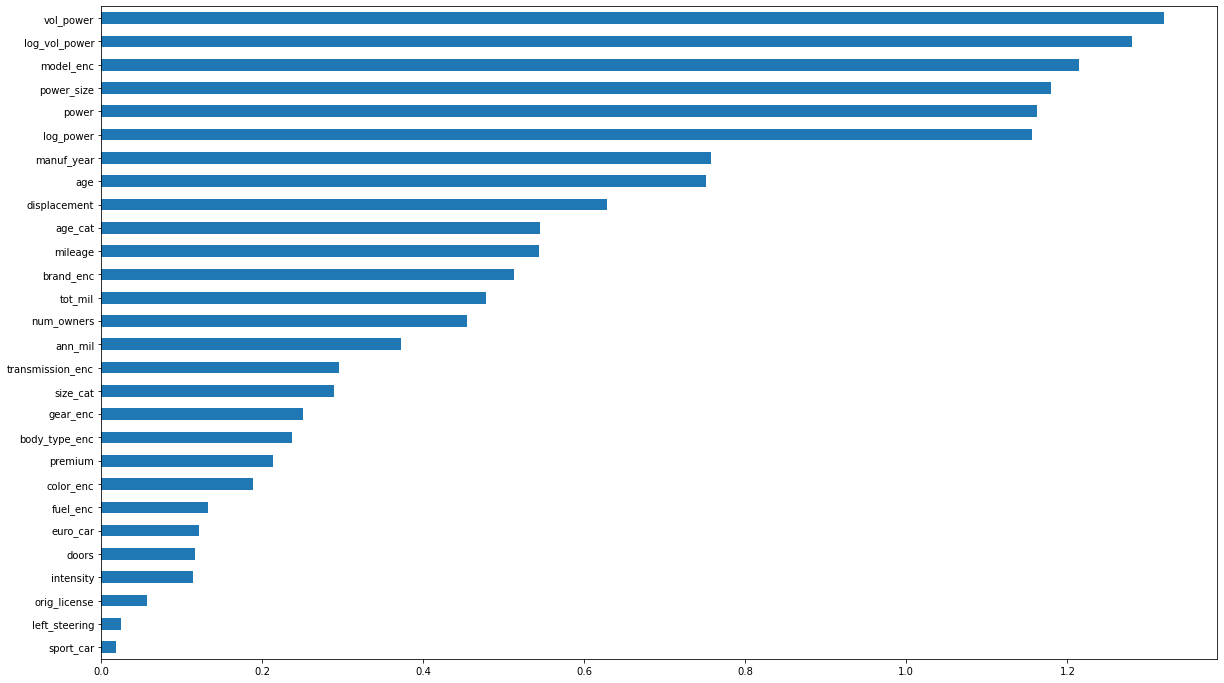

In [152]:

plt.figure(figsize=(20, 12))
#imp_cat = Series(mutual_info_regression(df[all_model_cols], data['default']), index=model_cols)
imp_cat = pd.Series(mutual_info_regression(df.query('train==1')[all_model_cols],df.query('train==1').price),index=all_model_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

Практически все признаки значимые. А что с корреляцией?


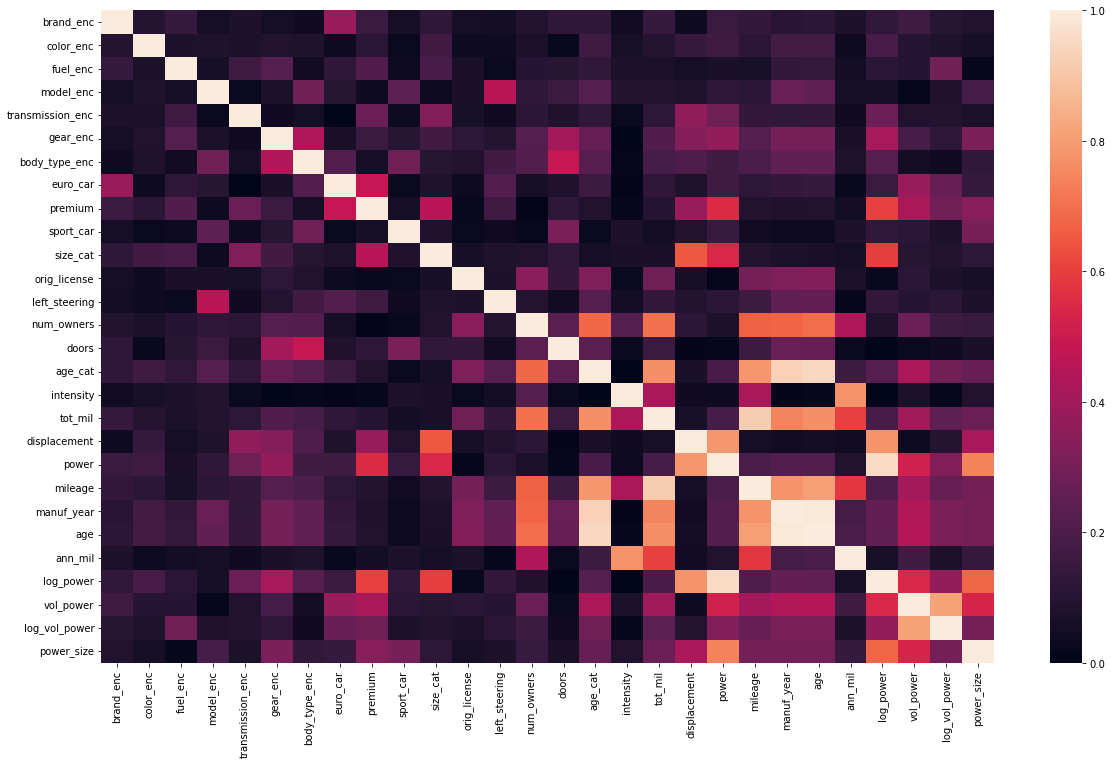

In [153]:
plt.figure(figsize=(20, 12))
sns.heatmap(df[all_model_cols].corr().abs(), vmin=0, vmax=1, annot = False);

Довольно много признаков с высокой корреляцией.  Выделим их

In [178]:
corr = df[all_model_cols].corr().abs()
corr_table = corr.unstack()
corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
corr_exclude_ones[corr_exclude_ones >= 0.70]  #0.85


manuf_year     age              1.000000
age            manuf_year       1.000000
power          log_power        0.953307
log_power      power            0.953307
age            age_cat          0.931516
age_cat        age              0.931516
               manuf_year       0.931516
manuf_year     age_cat          0.931516
tot_mil        mileage          0.921843
mileage        tot_mil          0.921843
vol_power      log_vol_power    0.813639
log_vol_power  vol_power        0.813639
displacement   power            0.786829
power          displacement     0.786829
mileage        age_cat          0.783581
age_cat        mileage          0.783581
displacement   log_power        0.778991
log_power      displacement     0.778991
age            mileage          0.778355
mileage        age              0.778355
manuf_year     mileage          0.778355
mileage        manuf_year       0.778355
age_cat        tot_mil          0.769394
tot_mil        age_cat          0.769394
age            t

В основном высокая корреляция связывает про новые и старые признаки, а также количественные признаки и категориальные на их основе.  Надо исключить то, что представляется менее важным для обучения модели (см график-торнадо выше).

In [21]:
p05 = reload(p05)

Построим и выведем во внешнюю библиотеку функцию создания новых признаков.

In [22]:
df = p05.engineer_features(df)

In [23]:
df.columns

Index(['body', 'brand', 'url', 'color', 'displacement', 'power', 'fuel',
       'mileage', 'model_year', 'model', 'doors', 'manuf_year', 'sell_id',
       'transmission', 'num_owners', 'gear', 'price', 'train', 'body_type',
       'orig_license', 'left_steering', 'size_cat', 'sport_car', 'euro_car',
       'premium', 'brand_enc', 'color_enc', 'fuel_enc', 'model_enc',
       'transmission_enc', 'gear_enc', 'body_type_enc', 'age', 'age_cat',
       'ann_mil', 'intensity', 'power_size', 'vol_power'],
      dtype='object')

In [24]:
rg_enc = p05.parse_ranging_encoder(df,cat_cols)
new_cat_cols, df = p05.apply_encoder(df, cat_cols, rg_enc)
print(new_cat_cols)

['brand_enc', 'color_enc', 'fuel_enc', 'model_enc', 'transmission_enc', 'gear_enc', 'body_type_enc']


In [25]:
cat_cols = ['brand', 'color', 'fuel', 'model', 'transmission',  'gear', 'body_type']
dig_cat = ['euro_car', 'premium', 'orig_license','left_steering','num_owners', 'doors', 'intensity'  ]
num_cols = [ 'power', 'mileage', 'age', 'ann_mil',  'vol_power', 'power_size' ]
help_cols = ['sell_id','body','url','model_year']
wrong_cols = ['displacement','manuf_year', 'log_power', 'log_vol_power', 'age_cat', 'tot_mil' ]
target = ['price']

Оценим новые признаки на рабочей модели.

In [26]:
model_cols = num_cols + new_cat_cols + dig_cat
print(p05.eval_data(df.query('train==1')[model_cols],df.query('train==1').price,'FE01'))

Eval: ExtEns AdaBst GradBst RanFrst done. 365.8865 sec
ExtEns     11.970694
AdaBst     36.694128
GradBst    12.000450
RanFrst    11.777999
Name: FE01, dtype: float64


In [27]:
rfr21 = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr21.fit(X,np.log(y))

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [28]:
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr21.predict(Xt))*0.78
# subm = tdf[['sell_id','price']]
subm.to_csv(f'211202_subm_01.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.269527e+05
1,1100549428,1.075122e+06
2,1100658222,1.263223e+06
3,1100937408,8.675356e+05
4,1101037972,7.241352e+05


Kaggle Score 17.9970

In [34]:
subm['price'] = np.exp(rfr21.predict(Xt))*0.72
subm.to_csv(f'./submissions/211202_subm_06.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,5.787256e+05
1,1100549428,9.924205e+05
2,1100658222,1.166052e+06
3,1100937408,8.008021e+05
4,1101037972,6.684325e+05


Kaggle Score 16.414

Текущий Kaggle Score после исправления ошибки с годом 16.414 (с поправкой 0.72) Были до исправления ошибки в этой точке 15.70981, 15.8257 и 15.8425.

### Проверка обоснованности предположения по моделям

Для проверки обучу две модели ExtraTreesRegressor, и GradientBoostingRegressor на полной обучающей выборке и проверю на тесте путем подачи данных на Каггл.

In [41]:
etr = ExtraTreesRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
etr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(etr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_10.csv', index=False)
subm.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


,sell_id,price
0,1100575026,6.530041e+05
1,1100549428,9.410952e+05
2,1100658222,1.066791e+06
3,1100937408,7.959560e+05
4,1101037972,6.683829e+05


Kaggle Score 16.452. Чуда не произошло, однако это наверное хороший кандидат на включение в стэкинг.

Еще один участник из стандартного пакета.

In [42]:
gbr = GradientBoostingRegressor(n_estimators=2000,   random_state=RANDOM_SEED, verbose=1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
gbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(gbr.predict(Xt))*0.78
subm.to_csv('./submissions/211202_subm_11.csv', index=False)
subm.head()

      Iter       Train Loss   Remaining Time 
         1           0.9082            2.53m
         2           0.7749            2.42m
         3           0.6649            2.26m
         4           0.5735            2.21m
         5           0.4985            2.22m
         6           0.4332            2.21m
         7           0.3797            2.19m
         8           0.3347            2.17m
         9           0.2982            2.18m
        10           0.2668            2.14m
        20           0.1208            2.25m
        30           0.0836            2.42m
        40           0.0705            2.35m
        50           0.0633            2.49m
        60           0.0584            2.39m
        70           0.0552            2.37m
        80           0.0523            2.33m
        90           0.0500            2.31m
       100           0.0481            2.28m
       200           0.0393            2.05m
       300           0.0349            1.84m
       40

,sell_id,price
0,1100575026,7.483781e+05
1,1100549428,1.025337e+06
2,1100658222,1.154330e+06
3,1100937408,8.654280e+05
4,1101037972,7.717938e+05


Kaggle Score 17.388

In [43]:
subm['price'] = np.exp(gbr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_12.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.908105e+05
1,1100549428,9.464646e+05
2,1100658222,1.065536e+06
3,1100937408,7.988566e+05
4,1101037972,7.124250e+05


Kaggle Score 15.31618 (Было до исправления ошибки 15.30687) Разрыв после исправления ошибки практически сократился.  Гипотеза о необходимости проверки результатов путем подачи предсказания на kagglе подтвердилась.

### Эксперименты с кодировщиками категорий

Во время постановки задачи ментор упомянул библиотеку category encoders. Этот кандидат для включения в scikit-learn содержит некоторое количество моделей для кодировки категориальных признаков.  Особенность некоторых признаков в задаче - их высокая кардинальность.  В этой связи возникло желание опробовать в деле несколько функций из этой библиотеки.


In [45]:
df[cat_cols].nunique()

brand            12
color            16
fuel              5
model           607
transmission      4
gear              3
body_type         6
dtype: int64

 В пространстве необработанных категорийных признаков осталось 3 признака с высокой кардинальностью и четыре признака с низкой кардинальностью, которые вполне могут быть эффективно преобразованы в набор индексных признаков.

In [47]:
print(new_cat_cols)

['brand_enc', 'color_enc', 'fuel_enc', 'model_enc', 'transmission_enc', 'gear_enc', 'body_type_enc']


In [49]:
high_card_cat = ['brand', 'color', 'model']
high_card_cat_enc = ['brand_enc', 'color_enc', 'model_enc']
low_card_cat = ['fuel',  'transmission',  'gear', 'body_type']

In [50]:
dummies = pd.get_dummies(df[low_card_cat])
dum_cat = list(dummies.columns); print(dum_cat)

Index(['fuel_B', 'fuel_D', 'fuel_E', 'fuel_G', 'fuel_H', 'transmission_AMT',
       'transmission_AT', 'transmission_CVT', 'transmission_MT', 'gear_AWD',
       'gear_FWD', 'gear_RWD', 'body_type_MPV', 'body_type_SUV',
       'body_type_coupe', 'body_type_f_back', 'body_type_sedan',
       'body_type_wagon'],
      dtype='object')


In [51]:
df = pd.concat([df, dummies], axis=1)

In [53]:
dum_cat = list(dum_cat)

In [57]:
p05 = reload(p05)

In [54]:
model_cols = num_cols + dum_cat + high_card_cat_enc + dig_cat
X = df.query('train==1')[model_cols]
y = df.query('train==1').price
print(p05.eval_data(X,y,'FE01'))

Eval: ExtEns AdaBst GradBst RanFrst done. 462.5962 sec
ExtEns     12.000214
AdaBst     35.590512
GradBst    11.973071
RanFrst    11.816702
Name: FE01, dtype: float64


Введение индексных признаков оказало позитивное влияние на GradBst и негативное на ансамбли. А что на Kaggle?

In [55]:
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_13.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,5.883123e+05
1,1100549428,9.940007e+05
2,1100658222,1.181236e+06
3,1100937408,7.934301e+05
4,1101037972,6.647247e+05


Kaggle 16.4412  Направление изменения признака сохраняется и на kaggle.

In [56]:
gbr = GradientBoostingRegressor(n_estimators=2000,   random_state=RANDOM_SEED, verbose=1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
gbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(gbr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_14.csv', index=False)
subm.head()

      Iter       Train Loss   Remaining Time 
         1           0.9082            3.44m
         2           0.7745            3.01m
         3           0.6638            2.88m
         4           0.5716            2.83m
         5           0.4959            2.86m
         6           0.4335            2.84m
         7           0.3783            2.82m
         8           0.3329            2.80m
         9           0.2949            2.76m
        10           0.2633            2.76m
        20           0.1180            2.64m
        30           0.0809            2.62m
        40           0.0680            2.56m
        50           0.0607            2.49m
        60           0.0566            2.48m
        70           0.0535            2.57m
        80           0.0512            2.54m
        90           0.0493            2.49m
       100           0.0476            2.45m
       200           0.0386            2.52m
       300           0.0346            2.24m
       40

,sell_id,price
0,1100575026,7.047561e+05
1,1100549428,9.607980e+05
2,1100658222,1.058303e+06
3,1100937408,7.943815e+05
4,1101037972,7.177123e+05


Kaggle 15.2194  Это пока лучший результат.

In [95]:
def target_encode(data,col,enc):
    tgt_name = col +'_tgt'
    x_col = dict()
    data[tgt_name] = 0
    column = data.query('train==1')[col].to_numpy()
    target = np.log(data.query('train==1').price.to_numpy())
    i = 0
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    for trn_index, _ in kf.split(column):
        enc.fit( column[trn_index], target[trn_index] )
        x_col[i] = enc.transform(data[col].to_numpy())
        i += 1
    data[tgt_name] = (x_col[0] + x_col[1] + x_col[2])/3
    return tgt_name, data

Функция расчета значения целевых признаков перекочевала в библиотеку функций после отладки.  С целевой кодировкой есть проблема переобучения.  Чтобы ее избежать, и генерировать признак отдельно заранее я решил сделать кросс-валидацию на 3 складках.  Кодировщик обучался на 2/3 обучающей выборки, затем делал вариант кодировки признака для полной обучающей и тестовой выборок одновременно. Этот вариант запоминался для последующего усреднения.  Итоговый вариант значений целевой кодировки получился усреднением трех вариантов целевой кодировки.

In [84]:
enc = ce.MEstimateEncoder(m=5)
new_name, df = p05.target_encode(df, 'brand', enc )

In [85]:
model_cols = num_cols + dum_cat +  dig_cat + ['color_enc', 'model_enc'] + [new_name]
X = df.query('train==1')[model_cols]
y = df.query('train==1').price
print(p05.eval_data(X,y,'FE01'))

Eval: ExtEns GradBst RanFrst done. 345.6992 sec
ExtEns     11.945598
GradBst    12.022838
RanFrst    11.793123
Name: FE01, dtype: float64


Сравним разные модели целевых кодировщиков из пакета category_encorders.

In [86]:
enc_models = { 'CatBst': ce.CatBoostEncoder(random_state=RANDOM_SEED),
               'MEst': ce.MEstimateEncoder(random_state=RANDOM_SEED, m=5),
               'GLMM':  ce.GLMMEncoder(random_state=RANDOM_SEED) }

eval = dict()
for enc_n in enc_models.keys():
    print('Encoding',enc_n )
    new_name, df = target_encode(df, 'brand', enc_models[enc_n])
    model_cols = num_cols + dum_cat + dig_cat + ['color_enc', 'model_enc'] + [new_name]
    X = df.query('train==1')[model_cols]
    y = df.query('train==1').price
    eval_n = 'CE_'+enc_n
    eval[eval_n] = p05.eval_data(X, y, eval_n)


Encoding CatBst
Eval: ExtEns GradBst RanFrst done. 347.9786 sec
Encoding MEst
Eval: ExtEns GradBst RanFrst done. 346.9738 sec
Encoding GLMM
Eval: ExtEns GradBst RanFrst done. 347.7319 sec


In [90]:
print(pd.concat(eval, axis=1))

          CECatBst     CEMEst     CEGLMM
ExtEns   11.957177  11.945598  11.945111
GradBst  12.022838  12.022838  12.022838
RanFrst  11.793123  11.793123  11.793123


Можно предположить, что Generalized Linear Mixed Model Encoder обеспечивает наиболее интересный результат.  Результат работы этого кодировщика остался последним в датафрейме.   Результаты работы кодировщика мне понравились тем, что кроме положительных целевых статистик в признаке есть и отрицательные. Кодировщик явно помогает подгонять будущие модели.


Посмотрим на kaggle c моделью Случайного леса.  На обучающих данных изменений не заметно.


In [91]:
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_15.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,5.893299e+05
1,1100549428,9.847821e+05
2,1100658222,1.174207e+06
3,1100937408,7.924749e+05
4,1101037972,6.628054e+05


Kaggle  16.33197  Тенденция к улучшению есть.

In [92]:
gbr = GradientBoostingRegressor(n_estimators=2000,   random_state=RANDOM_SEED, verbose=1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
gbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(gbr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_16.csv', index=False)
subm.head()

      Iter       Train Loss   Remaining Time 
         1           0.9082            3.48m
         2           0.7745            4.12m
         3           0.6638            3.67m
         4           0.5716            3.77m
         5           0.4959            3.81m
         6           0.4335            3.91m
         7           0.3783            3.86m
         8           0.3329            3.77m
         9           0.2946            3.65m
        10           0.2629            3.52m
        20           0.1156            3.25m
        30           0.0782            3.25m
        40           0.0649            3.30m
        50           0.0582            3.23m
        60           0.0542            3.21m
        70           0.0514            3.13m
        80           0.0494            3.02m
        90           0.0479            2.96m
       100           0.0465            2.90m
       200           0.0385            2.55m
       300           0.0346            2.26m
       40

,sell_id,price
0,1100575026,6.836358e+05
1,1100549428,9.481225e+05
2,1100658222,1.050360e+06
3,1100937408,7.877044e+05
4,1101037972,7.252634e+05


Kaggle = 15.29843 А здесь результат похуже будет, чем в прошлой итерации.  Похоже, что GradBust не нравятся целевые кодировщики.  Радует то, что результаты локального моделирования и проверки качества на Kaggle двигаются в одном направлении. Попробую закодировать все три высококардинальных признака.

In [96]:
p05 = reload(p05)

In [97]:
enc = ce.GLMMEncoder(random_state=RANDOM_SEED)
nn01, df = p05.target_encode(df, 'color', enc )
nn02, df = p05.target_encode(df, 'model', enc )
tgt_enc = [new_name, nn01, nn02]; print(tgt_enc)

['brand_tgt', 'color_tgt', 'model_tgt']


In [98]:
model_cols = num_cols + dum_cat + dig_cat + tgt_enc
p05.eval_data(df.query('train==1')[model_cols], df.query('train==1').price , 'CE02')

Eval: ExtEns GradBst RanFrst done. 359.4121 sec


ExtEns     11.684297
GradBst    11.828017
RanFrst    11.550701
Name: CE02, dtype: float64

In [99]:
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_17.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.782847e+05
1,1100549428,1.012053e+06
2,1100658222,1.150659e+06
3,1100937408,7.996145e+05
4,1101037972,6.793145e+05


Kaggle Score 16.1782,

In [100]:
gbr = GradientBoostingRegressor(n_estimators=2000,   random_state=RANDOM_SEED, verbose=1)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
gbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(gbr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_18.csv', index=False)
subm.head()

      Iter       Train Loss   Remaining Time 
         1           0.9063            4.02m
         2           0.7693            3.20m
         3           0.6576            2.94m
         4           0.5661            2.86m
         5           0.4869            2.83m
         6           0.4199            2.76m
         7           0.3642            2.80m
         8           0.3188            2.77m
         9           0.2798            2.73m
        10           0.2475            2.71m
        20           0.1021            2.53m
        30           0.0695            2.46m
        40           0.0590            2.39m
        50           0.0539            2.34m
        60           0.0504            2.30m
        70           0.0482            2.27m
        80           0.0464            2.40m
        90           0.0450            2.48m
       100           0.0436            2.45m
       200           0.0363            2.21m
       300           0.0328            2.03m
       40

,sell_id,price
0,1100575026,7.002192e+05
1,1100549428,9.361855e+05
2,1100658222,1.033615e+06
3,1100937408,7.695458e+05
4,1101037972,7.382029e+05


Kaggle Score 15.1890  Удалось улучшить общий результат.

#### Промежуточные выводы

Разраотан набор признаков. Излишне коррелирующие признаки (к-т Корреляции > 0.85) устранены исходя из выбора более важного показателя.
Проведены эксперименты и разработана модель целевой кодировки на основе пакета category_encorders. Особенность модели - новые признаки создаются один раз и снижается риск их потери при дальнейшей работе.  Функции созданы в библиотеке как encode_high_cardinal_categories и encode_low_cardinal_categories. Они будут отработаны на следующем рабочем листе.

Можно переходить к завершающей части работы - настройке и выбору моделей.